## Import

In [1]:
#Import libraries
import numpy as np
import scipy.stats as sp
import pandas as pd
import matplotlib.pyplot as plt

# Modeling Assignment 1

In [2]:
#Deterministic function, takes no parameters and always returns the same thing
#Contains data for problem and returns reformatted for math
def dailyVisits():
#Data, separated by commobidity count range 02 & 37
    visitDaily02 = pd.Series([1.72,2.74,3.82])/241
    visitDaily37 = pd.Series([5.16,6.82,7.67,9.62,11.17])/241    
#Data, mean daily visits for each physician & patient commorbidity count
    phys102 = pd.Series([380,372,269]*visitDaily02)
    phys137 = pd.Series([187,98,33,8,1]*visitDaily37)
    phys202 = pd.Series([230,272,240]*visitDaily02)
    phys237 = pd.Series([190,124,47,23,5]*visitDaily37)
#Format in dataFrames
    comorMat02 = pd.DataFrame({'phys1' : phys102,'phys2' : phys202})
    comorMat37 = pd.DataFrame({'phys1' : phys137,'phys2' : phys237})
#Combine and sum dataFrames
    comorMat02 = comorMat02.T
    comorMat37 = comorMat37.T
    comorMat02['DailyVisits'] = comorMat02.sum(axis=1)
    comorMat37['DailyVisits'] = comorMat37.sum(axis=1)
#Return daily visits for each physician of each kind of patient
    return pd.DataFrame({'0-2' : comorMat02['DailyVisits'],'3-7' : comorMat37['DailyVisits']})

In [3]:
#Deterministic function, takes no parameters and always returns the same thing
#Call dailyVisits()
#Apply time weights to '3-7' patients
def appMean():
    visits = dailyVisits()
    visits['3-7']['phys1'] = visits['3-7']['phys1']*2
    visits['3-7']['phys2'] = visits['3-7']['phys2']*2
    visits['DailyVisits'] = visits.sum(axis=1)
#Return average number of total daily appointments        
    return visits

In [4]:
#Call dailyVisits()
#Apply time weights to '3-7' patients
#Randomized version of appMean()
def appRand():
    visits = dailyVisits()
    visits = pd.DataFrame(sp.expon.rvs(visits))
    visits.columns = ['0-2','3-7']
    visits.index = ['phys1','phys2']
    visits['3-7']['phys1'] = visits['3-7']['phys1']*2
    visits['3-7']['phys2'] = visits['3-7']['phys2']*2
    visits['DailyVisits'] = visits.sum(axis=1)
#Return instance of total daily appointments, based on exponential sampling
    return visits


In [5]:
#Demo of average daily appointments
appMean()

,0-2,3-7,DailyVisits
phys1,11.205228,16.386058,27.591286
phys2,8.538091,20.445477,28.983568


In [6]:
#Demo of random daily appointments
appRand()

,0-2,3-7,DailyVisits
phys1,11.292680,18.236717,29.529397
phys2,8.763096,21.537441,30.300537


In [7]:
#Take the "simulate()" or "simulateShared()" functions and outputs relevant data
def simOutput(sim):
#Plot queue length for simulation for each day    
    plt.figure(0)
    sim.plot(legend=True)
    plt.show()
#Print maximum and average    
    print("Maximum Queue Length")
    print("")
    print(sim.max())
    print("")
    print("Average Queue Length")
    print("")
    print(sim.mean())
    print("")
#Print percentile
    percentile = pd.Series({
        'phys1:0-2':np.percentile(sim['phys1:0-2'],90),
        'phys1:3-7':np.percentile(sim['phys1:3-7'],90),
        'phys2:0-2':np.percentile(sim['phys2:0-2'],90),
        'phys2:3-7':np.percentile(sim['phys2:3-7'],90)})

    print("90th Percentile")
    print("")
    print(percentile)    

In [8]:
#Run simulation for N days with chosen number of daily appointment slots C1 and C2
def simulate(C1,C2,N):
#Initialize queue lengths at 0
    q102 = 0
    q137 = 0
    q202 = 0
    q237 = 0
#Initialize matrices which will hold timeseries of queue lengths at the end of each day    
    matq102 = pd.Series([])
    matq137 = pd.Series([])
    matq202 = pd.Series([])
    matq237 = pd.Series([])
#Run simulation for N days
    for i in range(N):
#Typecast random appointments to integers, i.e. no such thing as a fraction of an appt
        visits = appRand().astype(int)
        
        q102 = q102 + visits['0-2']['phys1']
        q137 = q137 + visits['3-7']['phys1']
        q202 = q202 + visits['0-2']['phys2']
        q237 = q237 + visits['3-7']['phys2']
#Calculate queue lengths for physician 1 for each random day
        if q102 + q137 <= C1:
            q102 = 0
            q137 = 0
            remainder1 = C1 - (q102 + q137)
        elif q137 >= C1:
            q137 = q137 - C1
            remainder1 = 0
        else:
            if q102 - (C1 - q137) >= 0:
                q102 = q102 - (C1 - q137)
                q137 = 0
                remainder1 = 0
            else:
                remainder1 = (q102 - (C1 - q137))*(-1)
                q102 = 0
#Calculate queue lengths for physician 2 for each random day
        if q202 + q237 <= C2:
            q202 = 0
            q237 = 0
            remainder2 = C2 - (q202 + q237)
        elif q237 >= C2:
            q237 = q237 - C2
            remainder2 = 0
        else:
            if q202 - (C2 - q237) >= 0:
                q202 = q202 - (C2 - q237)
                q237 = 0
                remainder2 = 0
            else:
                remainder2 = (q202 - (C2 - q237))*(-1)
                q202 = 0           
#Store that day's queue length at index for day in timeseries matrices 
        matq102[i] = q102
        matq137[i] = q137
        matq202[i] = q202
        matq237[i] = q237
#Return timeseries matrices formatted nicely        
    return pd.DataFrame({'phys1:0-2':matq102,'phys1:3-7':matq137,'phys2:0-2':matq202,'phys2:3-7':matq237})

In [9]:
#Run simulation for N days with daily appointment slots C1 and C2, where doctors share excess capacity
def simulateShared(dailySlots1,dailySlots2,N):
#Initialize queue lengths at 0
    q102 = 0
    q137 = 0
    q202 = 0
    q237 = 0
#Initialize matrices which will hold timeseries of queue lengths at the end of each day       
    matq102 = pd.Series([])
    matq137 = pd.Series([])
    matq202 = pd.Series([])
    matq237 = pd.Series([])
#Run simulation for N days    
    for i in range(N):
        visits = appRand().astype(int)
#Typecast random appointments to integers, i.e. no such thing as a fraction of an appt        
        q102 = q102 + visits['0-2']['phys1']
        q137 = q137 + visits['3-7']['phys1']
        q202 = q202 + visits['0-2']['phys2']
        q237 = q237 + visits['3-7']['phys2']
#Calculate queue lengths for physician 1 for each random day
        if q102 + q137 <= dailySlots1:
            q102 = 0
            q137 = 0
            remainder1 = dailySlots1 - (q102 + q137)
        elif q137 >= dailySlots1:
            q137 = q137 - dailySlots1
            remainder1 = 0
        else:
            if q102 - (dailySlots1 - q137) >= 0:
                q102 = q102 - (dailySlots1 - q137)
                q137 = 0
                remainder1 = 0
            else:
                remainder1 = (q102 - (dailySlots1 - q137))*(-1)
                q102 = 0
#Calculate queue lengths for physician 2 for each random day
        if q202 + q237 <= dailySlots2:
            q202 = 0
            q237 = 0
            remainder2 = dailySlots2 - (q202 + q237)
        elif q237 >= dailySlots2:
            q237 = q237 - dailySlots2
            remainder2 = 0
        else:
            if q202 - (dailySlots2 - q237) >= 0:
                q202 = q202 - (dailySlots2 - q237)
                q237 = 0
                remainder2 = 0
            else:
                remainder2 = (q202 - (dailySlots2 - q237))*(-1)
                q202 = 0
#Calculate shared excess capacity and adjust queue lengths            
        if q102 != 0 and remainder2 != 0:
            if q102 >= remainder2:
                q102 = q102 - remainder2
                remainder2 = 0
            elif q102 < remainder2:
                remainder2 = remainder2 - q102
                q102 = 0
        elif q202 !=0 and remainder1 != 0:
            if q202 >= remainder1:
                q202 = q202 - remainder1
                remainder2 = 0
            elif q202 < remainder1:
                remainder1 = remainder1 - q202
                q202 = 0   
#Store that day's queue length at index for day in timeseries matrices             
        matq102[i] = q102
        matq137[i] = q137
        matq202[i] = q202
        matq237[i] = q237
#Return timeseries matrices formatted nicely                
    return pd.DataFrame({'phys1:0-2':matq102,'phys1:3-7':matq137,'phys2:0-2':matq202,'phys2:3-7':matq237})

Simulation



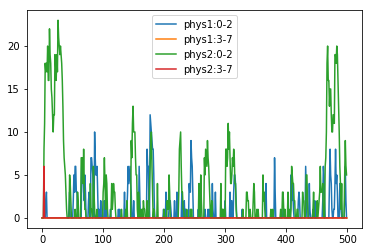

Maximum Queue Length

phys1:0-2    12
phys1:3-7     0
phys2:0-2    23
phys2:3-7     6
dtype: int64

Average Queue Length

phys1:0-2    1.022
phys1:3-7    0.000
phys2:0-2    3.188
phys2:3-7    0.012
dtype: float64

90th Percentile

phys1:0-2     4.0
phys1:3-7     0.0
phys2:0-2    11.0
phys2:3-7     0.0
dtype: float64

Shared Simulation



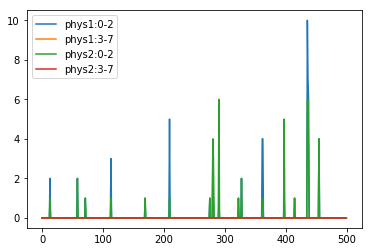

Maximum Queue Length

phys1:0-2    10
phys1:3-7     0
phys2:0-2     6
phys2:3-7     0
dtype: int64

Average Queue Length

phys1:0-2    0.120
phys1:3-7    0.000
phys2:0-2    0.102
phys2:3-7    0.000
dtype: float64

90th Percentile

phys1:0-2    0.0
phys1:3-7    0.0
phys2:0-2    0.0
phys2:3-7    0.0
dtype: float64


In [10]:
#Outputs for simulations C1 = 31, C2 = 32, N = 500
%matplotlib inline
print("Simulation")
print()
simOutput(simulate(31,32,500))
print()
print("Shared Simulation")
print()
simOutput(simulateShared(31,32,500))